### !!!Note: Scroll down, to the bottom of the file for final result

In this notebook I demonstrate augmenting the training dataset with Gaussian Noise using ART on the MNIST dataset, to defend against the HopSkipJumpAttack. Note that the pipeline is based on an ART Notebook Tutorial, which can be found [here](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_training_mnist.ipynb "Google Search")

# 1. Load prereqs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import HopSkipJump 
from art.defences.preprocessor import GaussianAugmentation

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Use this to disable eager execution mode of tensorflow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

# 2. Train and evaluate a baseline classifier

Load the classifier model:

In [3]:
path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

In [4]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

Evaluate the classifier performance on the first 100 original test samples:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Original test data (first 100 images):
Correctly classified: 100
Incorrectly classified: 0


Generate some adversarial samples:

In [6]:
attacker = HopSkipJump(classifier, verbose=True)
x_test_adv = attacker.generate(x_test[:100])

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

And evaluate performance on those:

In [7]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 0
Incorrectly classified: 100


Note, that the HopSkipJumpAttack finds very effcient adversarial examples, since the model misclassifies all of them.

# 3. Train a robust classifier on Gaussian augmented dataset 

Initialize an instance of the GaussianAugmentation() class, based on an optimal sigma-value as experimentally identified in [here](https://arxiv.org/pdf/1809.03113.pdf "Google Serach") and a augmented dataset of 5 times the original dataset.

In [8]:
augmenter = GaussianAugmentation(sigma=0.7, augmentation=True, ratio=5)

In [9]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False, preprocessing_defences=augmenter)

Note: the robust classifier has the same architecture as above, except the first dense layer has 1024 instead of 128 units. (This was recommend by Madry et al. (2017), Towards Deep Learning Models Resistant to Adversarial Attacks)

In [10]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test[:100]), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_robust_pred))

Original test data (first 100 images):
Correctly classified: 99
Incorrectly classified: 1


In [11]:
robust_classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1639424   
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

Perform robust training on augmented dataset.

In [12]:
robust_classifier.fit(x_train, y_train, nb_epochs=30, batch_size=50)

Train on 360000 samples
Epoch 1/30
360000/360000 [==============================] - 160s 444us/sample - loss: 0.5110 - accuracy: 0.9173
Epoch 2/30
360000/360000 [==============================] - 163s 452us/sample - loss: 0.1492 - accuracy: 0.9526
Epoch 3/30
360000/360000 [==============================] - 165s 459us/sample - loss: 0.1124 - accuracy: 0.9631
Epoch 4/30
360000/360000 [==============================] - 162s 449us/sample - loss: 0.0887 - accuracy: 0.9700
Epoch 5/30
360000/360000 [==============================] - 163s 452us/sample - loss: 0.0698 - accuracy: 0.9762
Epoch 6/30
360000/360000 [==============================] - 162s 449us/sample - loss: 0.0548 - accuracy: 0.9815
Epoch 7/30
360000/360000 [==============================] - 148s 411us/sample - loss: 0.0435 - accuracy: 0.9852
Epoch 8/30
360000/360000 [==============================] - 147s 408us/sample - loss: 0.0371 - accuracy: 0.9877 loss: 0.0371 - ac
Epoch 9/30
360000/360000 [==============================] - 14

# 4. Evaluate the robust classifier

Evaluate the robust classifier's performance on the original test data:

In [13]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test[:100]), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_robust_pred))

Original test data (first 100 images):
Correctly classified: 100
Incorrectly classified: 0


Evaluate the robust classifier's performance on the adversarial test data (black-box setting):

In [14]:
attacker_robust = HopSkipJump(robust_classifier, verbose=True)
x_test_adv_robust = attacker_robust.generate(x_test[:100])

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_robust_pred))

Adversarial test data (first 100 images):
Correctly classified: 0
Incorrectly classified: 100


Compare the performance of the original and the robust classifier over a range of eps values:

In [16]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    x_test_adv_robust = attacker_robust.generate(x_test[:100])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

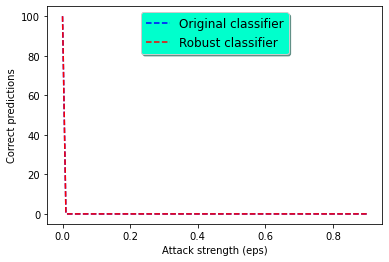

In [17]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()

Note that both, the original and robust classifier accuracy immediatly drop to zero. While this might simply be an implementation issue, it could also be due to the fact that the HSJA is completly immune to at least data augmentation with Gaussian noise. Within the scope of this seminar, I will not go deeper into discussing this result, since it opposes the argumentation by Li et al.